In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
#from sklearn.pipeline import make_pipeline, make_union
import statsmodels.api as sm
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from climada.util.constants import DEF_CRS

idx = pd.IndexSlice
#from sklearn_xarray import Stacker, Select

In [2]:
##function definition
from functions import *
from climada_functions import *
from constants import * 

## Select and load data

In [3]:
## select data
#select variable (cmip6 naming)
selvar = 'ua'
pathinvar = pathcmip6+'ua/'

#preprocessing 
gst_fact = 1.67
qt = 0.98
cut=5E5
min_lat=10
max_lat=80
min_lon=-177.5
max_lon=177.5
##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["rg_25"] #base resolution regridded
timeres = ["mon"]
domain = ["NH"]
season = ["winE"]
scen = ["allscens"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season
basenamemet = sep.join(lst_bn)



## Load indices

In [4]:
#get sfcT
sfcT_fn = "diff_all_remote_indices_O20_sp_avg_allmods_historical_ssp585.csv"
sfcT = pd.read_csv(pathcirc+sfcT_fn,header=[0],index_col=[0,1]).loc[:,["sfcT"]]

#get remote indices
dind_fn1 = "diff_all_remote_indices_O20_sp_avg_allmods_historical_ssp585.csv"
dind_fn2 = "diff_custom_indices_sp_avg_allmods_historical_ssp585.csv"
dind_fn3 = "diff_weather_indices_CU21_sp_avg_allmods_historical_ssp585.csv"


preds0 = ["pol","trop","strat"]
preds1 = ["pol","trop","strat","NAWH","Nino4-Nino3"]
preds2 = ["baro","TCWV"]
preds3 = ["NAO","EA","EAWR","SCA"]
dind_df1 = pd.read_csv(pathcirc+dind_fn1,header=[0],index_col=[0,1]).iloc[:,1:]
dind_df2 = pd.read_csv(pathcirc+dind_fn2,header=[0],index_col=[0,1])
dind_df3 = pd.read_csv(pathcirc+dind_fn3,header=[0],index_col=[0,1])

#concat 
dind_df_all = pd.concat([dind_df1,dind_df2,dind_df3],axis=1)

In [5]:
#drop Kace because outlier!
dind_df_all = dind_df_all.drop('KACE-1-0-G',axis=0,level=0)
sfcT = sfcT.drop('KACE-1-0-G',axis=0,level=0)
#drop 'CNRM-CM6-1-HR' because outlier!
dind_df_all = dind_df_all.drop('CNRM-CM6-1-HR',axis=0,level=0)
sfcT = sfcT.drop('CNRM-CM6-1-HR',axis=0,level=0)

In [6]:
##prepare predictors
#select df
sel_dind_memsep_df = dind_df_all.copy()
sel_sfcT_memsep = sfcT

#memmean 
#sel_dind_df = sel_dind_memsep_df.groupby("model").mean()
#sel_sfcT = sel_sfcT_memsep.groupby("model").mean()

#take first member instead of member mean
sel_dind_df = sel_dind_memsep_df.loc[idx[:,0],:]
sel_sfcT = sel_sfcT_memsep.loc[idx[:,0],:]

sel_sfcT.index = sel_sfcT.index.droplevel(level=1)
sel_dind_df.index = sel_dind_df.index.droplevel(level=1)

#normalize by sfcT
sel_dind_df = sel_dind_df / sel_sfcT.values

# anomalies
an_dind_df = sel_dind_df.copy()
an_dind_df = sel_dind_df-sel_dind_df.mean()

# standardized
std_an_dind_df = an_dind_df.copy()
std_an_dind_df = an_dind_df/sel_dind_df.std()

## Prepare model target variable

In [7]:
#select vars
modlist = modlist_ua + ['ACCESS-ESM1-5']
modlist.remove('KACE-1-0-G')
modlist.remove('CNRM-CM6-1-HR')
memname_df = pd.read_csv('/home/lseverino/MT/metadata/memnames_ssp585_hist_SWM.csv',header=[0,1],index_col=0)
nmods = len(modlist)
pastname = 'historical'
futname = 'ssp585'
timeres='day'
nmems_max = 1
memrange = np.arange(nmems_max)
qt = 0.98
#lonout = np.arange(min_lon,max_lon,2.5)
#lonout = (lonout + 180) % 360 - 180
#lonout.sort()
lonout = np.arange(min_lon,max_lon,2.5)
latout = np.arange(min_lat,max_lat,2.5)
normresp = True #normalize by global warming


In [8]:
#intiate ds to save result
namep = pastname
namef = futname
named = futname+'-'+pastname
#qtgust_ds = xr.DataArray(np.zeros([latout.size, lonout.size,nmods ,nmems_max]), 
#                                          coords=[latout, lonout, modlist, memrange], dims=['lat','lon','model','member'], name=nameds)


past_da = xr.DataArray(np.nan*np.empty([latout.size, lonout.size,nmods ,nmems_max]), 
                                          coords=[latout, lonout, modlist, memrange], dims=['lat','lon','model','member'], name=namep)  
fut_da = xr.DataArray(np.nan*np.empty([latout.size, lonout.size,nmods ,nmems_max]), 
                                          coords=[latout, lonout, modlist, memrange], dims=['lat','lon','model','member'], name=namef)  
diff_da = xr.DataArray(np.nan*np.empty([latout.size, lonout.size,nmods ,nmems_max]), 
                                          coords=[latout, lonout, modlist, memrange], dims=['lat','lon','model','member'], name=named)  


In [9]:
#loop over the models
Ts_df = sel_sfcT
for modid, modname in enumerate(modlist):  
    
    #read netcdf
    fn = make_fn([modname],basenamemet,filetype=".nc")
    ncdf = xr.open_dataset(pathinvar+fn)
    ncdfw = ncdf[[pastname,futname]]
    
    #apply gust factor
    #gust_ds = gst_fact*ncdfw
    
    #get 98 quantile
    gust_mean_ds = ncdfw.mean(dim=timeres)
    #memmean
    gust_mean_ds = gust_mean_ds.mean(dim="member")
    
    #regrid
    gust_mean_ds = gust_mean_ds.interpolate_na(dim="lon", method="linear")
    gust_mean_ds = gust_mean_ds.interpolate_na(dim="lat", method="linear")
    gust_mean_ds = gust_mean_ds.interp(coords={"lat":latout,"lon":lonout})
   
    #compute fut -past diff
    gust_mean_past = gust_mean_ds[pastname]
    gust_mean_fut = gust_mean_ds[futname]
    gust_mean_diff = gust_mean_fut - gust_mean_past
    
    members = memname_df.loc[modname,pastname]
    nmems = max(nmems_max - members.isna().sum(),1)
    range_mems = list(range(nmems))
    if normresp:
        Tsmem = Ts_df.loc[modname].values
        gust_mean_diff = gust_mean_diff/Tsmem
    #write to ds
    past_da.loc[{"model":modname,'member':0}] = gust_mean_past
    fut_da.loc[{"model":modname,'member':0}] = gust_mean_fut
    diff_da.loc[{"model":modname,'member':0}] = gust_mean_diff

U850_ds = xr.merge([past_da,fut_da,diff_da])

## Simple regression on q98 of wind
1) Select simulation
2) Intiate df to save results
3) Loop over models, compute q98 fut-past diff, regrid and concat into the same array
5) regression on each gridcell of the q98 map



In [10]:
##select simulation

#models
modlist = modlist_ua + ['ACCESS-ESM1-5']
modlist.remove('KACE-1-0-G')
modlist.remove('CNRM-CM6-1-HR')

#modlist.remove('MIROC-ES2L')


#specify regression model
#addres = False
#addsfcT = False
#mem_avg = True

#select predictors
#preds = ["pol","trop","strat","NAWH","Nino4-Nino3"] #predictors
#preds = ["NAO","EAWR","SCA","EA"]
#preds = ["baro","TCWV"] #predictors
preds = ["pol","trop","strat","NAWH","Nino4-Nino3","NAO","EAWR","SCA","EA","baro","TCWV"] #predictors


In [11]:
#remove first member of KACE because outlier
#dind_df_all_rm = dind_df_all.drop('KACE-1-0-G',axis=0,level=0)
#sfcT_rm = sfcT.drop('KACE-1-0-G',axis=0,level=0)
dind_df_all_rm = dind_df_all.copy()
sfcT_rm = sfcT.copy()

In [12]:
#select and process target var

resp_ds = U850_ds[futname+"-"+pastname].sel(model=modlist)#select models 
#resp_ds = resp_ds.drop_sel(model='KACE-1-0-G') #remove KACE

In [13]:
#initiate arrays
nlat = len(latout)
nlon = len(lonout)
arr_dict = {}
arr_dict_pval = {}
to_save = preds
for item in to_save:
    arr_dict[item] = xr.DataArray(np.nan*np.ones([latout.size, lonout.size]), 
                                          coords=[latout, lonout], dims=['lat','lon'], name=item)
for item in preds:
    arr_dict_pval[item] = xr.DataArray(np.nan*np.ones([latout.size, lonout.size]), 
                                          coords=[latout, lonout], dims=['lat','lon'], name=item)
        

In [14]:
##select indices and response statsmodel

yy = resp_ds

for pred in preds:
    X = std_an_dind_df[pred]
    try:
        X.index = X.index.droplevel(0)
    except:
        pass
    X = X.reindex(yy.model)
    X = sm.add_constant(X) # adding a constant
    for ii in np.arange(0,nlat,1):
        for jj in np.arange(0,nlon,1):
    #         ----------------------------
            #select response variable at gridpoint
            y_grid_point = yy.isel(lat=ii,lon=jj).values.flatten()
        
            #construct model
            lm = sm.OLS(y_grid_point, X) # describe model
            fit = lm.fit() # fit model
            
            #save to array
            #arr_dict["Rsq"][ii,jj] = fit.rsquared
            #arr_dict["adj_Rsq"][ii,jj] = fit.rsquared_adj
            
            arr_dict[pred][ii,jj] = fit.params[pred]
                
            arr_dict_pval[pred][ii,jj] = fit.pvalues[pred]
            
res_ds2 = xr.Dataset(arr_dict)
pval_ds = xr.Dataset(arr_dict_pval)

In [15]:
#initiate arrays
nlat = len(latout)
nlon = len(lonout)
arr_dict_rob = {}
arr_dict_pval_rob = {}
to_save = preds
for item in to_save:
    arr_dict_rob[item] = xr.DataArray(np.nan*np.ones([latout.size, lonout.size]), 
                                          coords=[latout, lonout], dims=['lat','lon'], name=item)
for item in preds:
    arr_dict_pval_rob[item] = xr.DataArray(np.nan*np.ones([latout.size, lonout.size]), 
                                          coords=[latout, lonout], dims=['lat','lon'], name=item)

In [16]:
##Robust MLR

yy = resp_ds

for pred in preds:
    X = std_an_dind_df[pred]
    try:
        X.index = X.index.droplevel(0)
    except:
        pass
    X = X.reindex(yy.model)
    X = sm.add_constant(X) # adding a constant
    for ii in np.arange(0,nlat,1):
        for jj in np.arange(0,nlon,1):
    #         ----------------------------
            #select response variable at gridpoint
            y_grid_point = yy.isel(lat=ii,lon=jj).values.flatten()
        
            #construct model
            lm = sm.RLM(y_grid_point, X, M=sm.robust.norms.TukeyBiweight()) # describe model
            fit = lm.fit() # fit model       
            
            #Rsquared
            #yfit = fit.fittedvalues
            rsq = comp_rsq(fit,y_grid_point)
            adj_rsq = comp_adj_rsq(fit,y_grid_point,X)
            #arr_dict_rob["Rsq"][ii,jj] = rsq
            #arr_dict_rob["adj_Rsq"][ii,jj] = adj_rsq
        
            #save to array
            arr_dict_rob[pred][ii,jj] = fit.params[pred]
                    
            arr_dict_pval_rob[pred][ii,jj] = fit.pvalues[pred]
        
res_ds_rob = xr.Dataset(arr_dict_rob)
pval_ds_rob = xr.Dataset(arr_dict_pval_rob)


## Plot indices

In [17]:
#constants
coefs = ["pol","trop","strat","NAWH","Nino4-Nino3","NAO","SCA","EA","EAWR","baro","TCWV","const"]


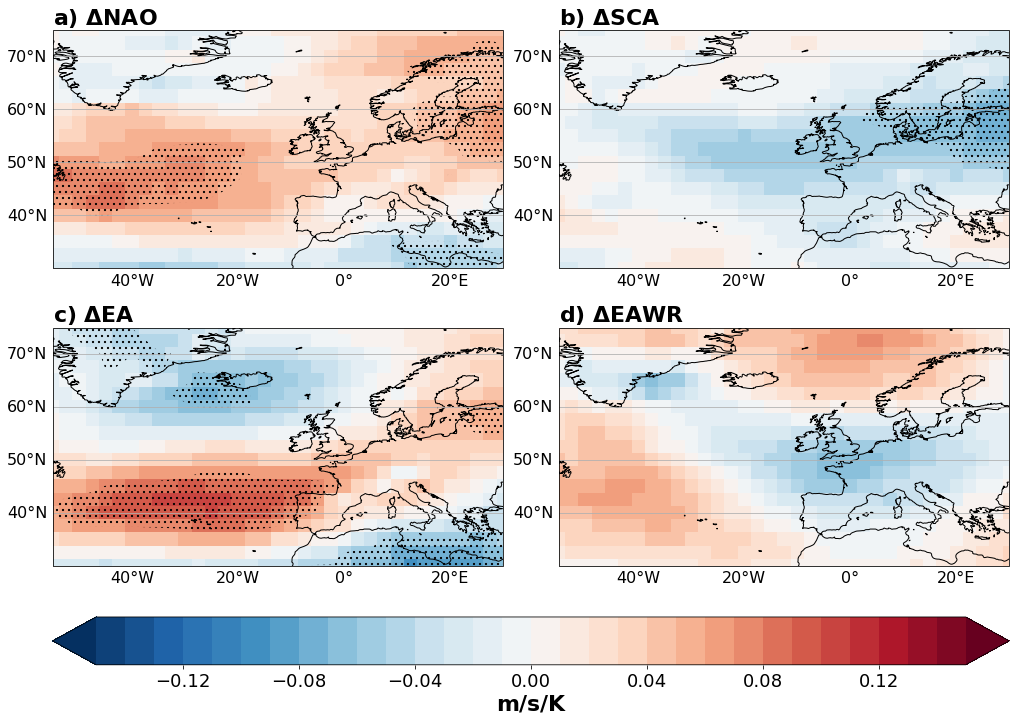

In [25]:
#select data
data = res_ds2
data_pval = pval_ds
to_plot = data.keys()
to_plot = ["NAO","SCA","EA","EAWR"]
labels = ["a) "+r"$\bf{\Delta NAO}$","b) "+r"$\bf{\Delta SCA}$","c) "+r"$\bf{\Delta EA}$","d) "+r"$\bf\Delta EAWR}$"]
nfields = len(to_plot)
add_pvals = True
field_sign = True
alpha = 0.1
alphafdr = alpha


#plotting params
saving = True
nrows = 2
extent = (-55,30,30,70)
#nrows = np.max((1,round(nfields/2)+nfields%2))
ncols = 2
#namings
savelocation="results/figures/CircScen/coefs/"
savefileName = make_fn(['slr','U850','OLS','reg','q98','coefs']+to_plot,filetype='.png')

#color levels
colorbarMin=-0.15
colorbarMax=0.15
colorspace=0.01
clevel_coef = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

colorbarMin=0
colorbarMax=0.5
colorspace=0.1
clevel_R = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

#hatches pvals
hatches =  ['..','']

#initiate plot
fig = plt.figure(constrained_layout=True,figsize=(7*ncols,5*nrows))
axs = fig.subplots(nrows=nrows, ncols=ncols,sharex=False,sharey=False,subplot_kw={'projection': ccrs.PlateCarree()}).flatten()

for i,varname in enumerate(to_plot):
    axi = axs[i]
    da = data[varname]
    label = labels[i]
    
    if varname in coefs:
        clevs = clevel_coef
        color = 'RdBu_r'
        if normresp:
            clabel = 'm/s/K'
        else:
            clabel = 'm/s'
    else:
        clevs = clevel_R
        color = 'viridis'
        clabel = 'Explained variance (%)'
    
    #clevs = dict_cbar[varname][0]
    #color = dict_cbar[varname][1]

    h = da.plot(ax=axi,extend='both',levels=clevs,cmap=color,add_colorbar=False)
    #
    ##plot the colorbar:
    #cbar = fig.colorbar(h, ax=axi,orientation='vertical', fraction=0.03, pad=0.05)
    #cbar.ax.tick_params(labelsize=12) 
    #
    ##label = labels[i]
    #cbar.set_label(label=label,fontsize=12,fontweight='bold')
    # coastlines
    axi.coastlines()
    axi.set_extent(extent)
    axi.set_visible(True)
    axi.set_title(label,fontsize=24,fontweight='bold',loc='left')
    gl = axi.gridlines(crs=ccrs.PlateCarree(), draw_labels={"bottom": "x", "left": "y"})
    gl.xlines = False
    gl.xlabel_style = {'size': 16, 'color': 'black'}#,'weight': 'bold'
    gl.ylabel_style = {'size': 16, 'color': 'black'}#,'weight': 'bold'
    #pvals
    if add_pvals:
        if varname in preds+["const"]:
            da_pv = data_pval[varname]
            if field_sign:
                ps = da_pv.to_numpy().flatten()
                ps.sort()
                Ntests = len(ps)
                test = ps[ps<=np.arange(1,Ntests+1)*alphafdr/Ntests]
                if np.any(test):
                    pfdr = np.max(test)
                else: 
                    print("/!\ No field significance for: "+varname)
                    continue
                p_levels = [0.0, pfdr]
            else:
                p_levels = [0.0, alpha]
            
            da_pv.plot.contourf(ax=axi,colors='none',levels=p_levels,hatches=hatches,extend='neither',add_colorbar=False)
            axi.set_title(label,fontsize=22,fontweight='bold',loc='left')
        
#add colorbar
cbar = fig.colorbar(h, ax=axs,orientation='horizontal',extendrect=False,fraction=0.1, pad=0.05)
cbar.ax.tick_params(labelsize=18) 

#label = labels[i]
cbar.set_label(label=clabel,fontsize=22,fontweight='bold')
#axi.set_title(varname,fontsize=20,fontweight='bold')
if saving:
    fig.savefig(savelocation+savefileName,transparent=False,bbox_inches='tight')

## Plot U850 wind fields

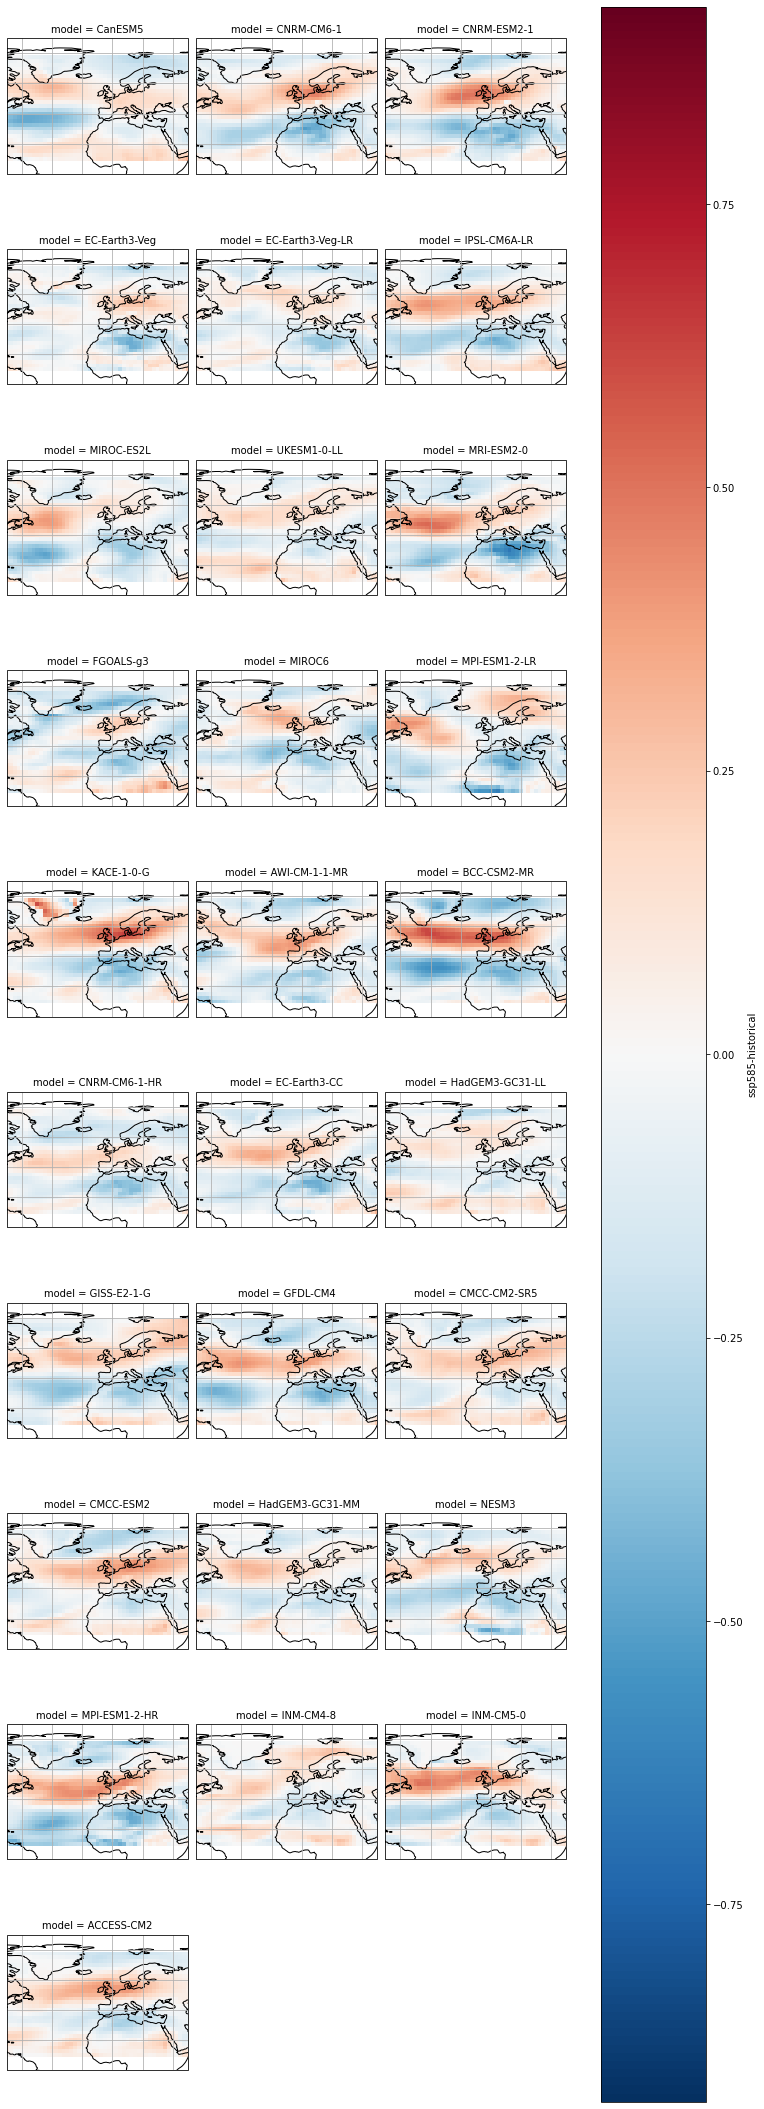

In [361]:
modlist = modlist_ua
data = U850_ds[futname+'-'+pastname]

p = data.plot(x="lon",y="lat",row="model",col_wrap=3,subplot_kws={'projection': ccrs.PlateCarree()})
for ax in p.axes.flat:
    ax.set_extent((-70,50,0,90))
    ax.coastlines()
    ax.gridlines()

In [362]:
 data.plot??

Signature:     
data.plot(
    row=None,
    col=None,
    col_wrap=None,
    ax=None,
    hue=None,
    rtol=0.01,
    subplot_kws=None,
    **kwargs,
)
Type:           _PlotMethods
String form:    <xarray.plot.plot._PlotMethods object at 0x7f7778153f70>
File:           ~/.conda/envs/climada_env/lib/python3.8/site-packages/xarray/plot/plot.py
Source:        
class _PlotMethods:
    """
    Enables use of xarray.plot functions as attributes on a DataArray.
    For example, DataArray.plot.imshow
    """

    __slots__ = ("_da",)

    def __init__(self, darray):
        self._da = darray

    def __call__(self, **kwargs):
        return plot(self._da, **kwargs)

    # we can't use functools.wraps here since that also modifies the name / qualname
    __doc__ = __call__.__doc__ = plot.__doc__
    __call__.__wrapped__ = plot  # type: ignore[attr-defined]
    __call__.__annotations__ = plot.__annotations__

    @functools.wraps(hist)
    def hist(self, ax=None, **kwargs):
        return hist

In [357]:
ax.set_extent??

Signature: ax.set_extent(extents, crs=None)
Source:   
    def set_extent(self, extents, crs=None):
        """
        Set the extent (x0, x1, y0, y1) of the map in the given
        coordinate system.

        If no crs is given, the extents' coordinate system will be assumed
        to be the Geodetic version of this axes' projection.

        Parameters
        ----------
        extents
            Tuple of floats representing the required extent (x0, x1, y0, y1).
        """
        # TODO: Implement the same semantics as plt.xlim and
        # plt.ylim - allowing users to set None for a minimum and/or
        # maximum value
        x1, x2, y1, y2 = extents
        domain_in_crs = sgeom.polygon.LineString([[x1, y1], [x2, y1],
                                                  [x2, y2], [x1, y2],
                                                  [x1, y1]])

        projected = None

        # Sometimes numerical issues cause the projected vertices of the
        # requested extent